# CS5616 - NLP - A4 - Text Classification

## 209338R - KATS Jayathilaka

#### -----------------------------------------------------------------------------------------------------

### 1. Importing and downloading NLTK Library and importing all other libraries

In [196]:
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer 
from nltk import pos_tag
from spellchecker import SpellChecker
import os
import re
import time
import string
import pandas as pd
import numpy as np

#### You have to change this directory according to your system. Otherwise, nltk.download() will always be invoked.

In [56]:
# I am KATS Jayathilaka - SINGHABAHU is my nickname
NLTK_DATA_PATH_CHECK = '/home/singhabahu/nltk_data/'

In [57]:
if not os.path.exists(NLTK_DATA_PATH_CHECK):
    nltk.download()
    nltk.download('stopwords')
    nltk.download('punkt')
    nltk.download('wordnet')

### 2. Loading Raw Data

In [58]:
d_file = open('5000TravelQuestionsDataset.csv', encoding="latin-1")

df = pd.read_csv(d_file, header=None)
df.columns = ['text', 'class1', 'class2']

df.head()

,text,class1,class2
0,What are the special things we (husband and me...,TTD,TTDSIG
1,What are the companies which organize shark fe...,TTD,TTDOTH
2,Is it safe for female traveller to go alone to...,TGU,TGUHEA
3,What are the best places around Cape Town for ...,TTD,TTDSIG
4,What are the best places to stay for a family ...,ACM,ACMOTH


### 3. Preprocessing

#### 3.1.Removing mistakenly entered `class1` and `class2` entries as follows.

##### 3.1.1. Stripping trailing and leading whitespaces and linebreaks from `class1` column

In [59]:
# coarse classes
df['class1'].value_counts()

TGU      1217
TTD      1139
TRS      1011
ACM       720
FOD       521
ENT       214
WTH       172
TGU\n       3
\nENT       2
TTD\n       1
Name: class1, dtype: int64

In [60]:
df.groupby('class1').get_group('TGU\n')

,text,class1,class2
524,Has anyone planned a simple wedding by themsel...,TGU\n,TGUPLN
3145,What are the Trans-Mongolian stop recommendati...,TGU\n,TGUOTH
3333,What is a good Civil Ceremony Venue for a wedd...,TGU\n,TGUOTH


In [61]:
df.groupby('class1').get_group('\nENT')

,text,class1,class2
3750,What are the best areas of town this year for ...,\nENT,ENTFES
3751,What to do on Riverwalk at Christmas time ?,\nENT,ENTFES


In [62]:
df.groupby('class1').get_group('TTD\n')

,text,class1,class2
3710,what is the best Zoo in Denmark ?,TTD\n,TTDSIG


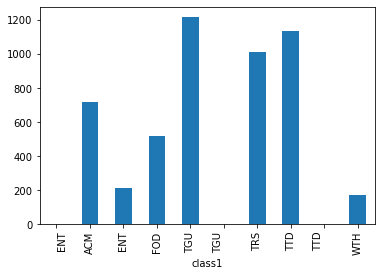

In [63]:
df.groupby('class1').text.count().plot.bar()

In [64]:
df['class1'] = df['class1'].str.strip()

##### Now there are exactly 7 coarse classes visible.

In [65]:
df['class1'].value_counts()

TGU    1220
TTD    1140
TRS    1011
ACM     720
FOD     521
ENT     216
WTH     172
Name: class1, dtype: int64

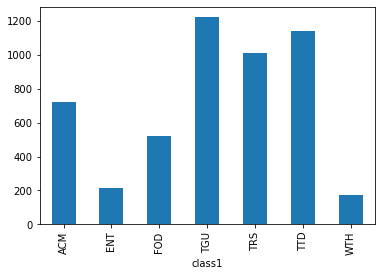

In [66]:
df.groupby('class1').text.count().plot.bar()

##### 3.1.2. Stripping trailing and leading whitespaces and linebreaks from `class2` column

In [67]:
# fine classes
df['class2'].value_counts()

TTDSIG      511
ACMHOT      342
TTDSPO      233
FODBAK      221
ACMOTH      207
           ... 
TTDSPO\n      1
TTDSHP\n      1
TGUCIG\n      1
FODBAK\n      1
\nWTHOTH      1
Name: class2, Length: 79, dtype: int64

In [68]:
df.groupby('class2').get_group('FODBAK\n')

,text,class1,class2
760,Can you suggest your favorite food stands for ...,FOD,FODBAK\n


In [69]:
df.groupby('class2').get_group('TTDSPO\n')

,text,class1,class2
3429,Where in Taormina can you watch Premier League...,TTD,TTDSPO\n


In [70]:
df.groupby('class2').get_group('ACMOTH\n')

,text,class1,class2
3567,What are the recommended reasonable accomodati...,ACM,ACMOTH\n


In [71]:
df.groupby('class2').get_group('TTDSIG\n')

,text,class1,class2
2601,What sites and places and activities are achie...,TTD,TTDSIG\n


In [72]:
df.groupby('class2').get_group('\nWTHOTH')

,text,class1,class2
4926,How is the weather in october in hampton?,WTH,\nWTHOTH


##### There are other mistakenly entered entries as well because here there are only 5 wrong groups from 79. But, there should be only 63 fine class labels. 

In [73]:
df['class2'] = df['class2'].str.strip()

##### Now there are only 63 fine classes visible

In [74]:
df['class2'].value_counts()

TTDSIG    512
ACMHOT    342
TRSOTH    242
TTDSPO    234
FODBAK    222
         ... 
ACMCAR      5
ACMBEA      5
TRSLIC      4
TGURES      3
TRSGAS      2
Name: class2, Length: 63, dtype: int64

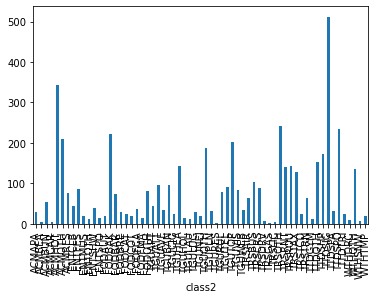

In [75]:
df.groupby('class2').text.count().plot.bar()

#### 3.2. Advanced Preprocessing Techniques

##### 3.2.1. Removing numbers

In [76]:
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

df['preprocessed_text'] = df['text'].apply(remove_numbers)
df['preprocessed_text']

0       What are the special things we (husband and me...
1       What are the companies which organize shark fe...
2       Is it safe for female traveller to go alone to...
3       What are the best places around Cape Town for ...
4       What are the best places to stay for a family ...
                              ...                        
4995    What is the best area to be based for sightsee...
4996    What are the good value traditional bars and r...
4997       What are the hotels near Alicante bus station?
4998       Where to stay in La Gomera to mountain biking?
4999    Is it possible to take a train trip from Santi...
Name: preprocessed_text, Length: 5000, dtype: object

##### 3.2.2. Removing punctuation marks

In [77]:
df['preprocessed_text'] = df['preprocessed_text'].str.translate(str.maketrans('','', string.punctuation))
df['preprocessed_text']

0       What are the special things we husband and me ...
1       What are the companies which organize shark fe...
2       Is it safe for female traveller to go alone to...
3       What are the best places around Cape Town for ...
4       What are the best places to stay for a family ...
                              ...                        
4995    What is the best area to be based for sightsee...
4996    What are the good value traditional bars and r...
4997        What are the hotels near Alicante bus station
4998        Where to stay in La Gomera to mountain biking
4999    Is it possible to take a train trip from Santi...
Name: preprocessed_text, Length: 5000, dtype: object

##### 3.2.3. Removing leading and trailing white spaces

In [78]:
df['preprocessed_text'] = df['preprocessed_text'].str.strip()
df['preprocessed_text']

0       What are the special things we husband and me ...
1       What are the companies which organize shark fe...
2       Is it safe for female traveller to go alone to...
3       What are the best places around Cape Town for ...
4       What are the best places to stay for a family ...
                              ...                        
4995    What is the best area to be based for sightsee...
4996    What are the good value traditional bars and r...
4997        What are the hotels near Alicante bus station
4998        Where to stay in La Gomera to mountain biking
4999    Is it possible to take a train trip from Santi...
Name: preprocessed_text, Length: 5000, dtype: object

##### 3.2.4. Converting to lowercase

In [79]:
df['preprocessed_text'] = df['preprocessed_text'].str.lower()
df['preprocessed_text']

0       what are the special things we husband and me ...
1       what are the companies which organize shark fe...
2       is it safe for female traveller to go alone to...
3       what are the best places around cape town for ...
4       what are the best places to stay for a family ...
                              ...                        
4995    what is the best area to be based for sightsee...
4996    what are the good value traditional bars and r...
4997        what are the hotels near alicante bus station
4998        where to stay in la gomera to mountain biking
4999    is it possible to take a train trip from santi...
Name: preprocessed_text, Length: 5000, dtype: object

##### 3.2.5. Removing stop words

In [53]:
def remove_english_stop_words(text):
    tokens = nltk.word_tokenize(text)
    filtered_words = [token for token in tokens if not token in stopwords.words('english')]
    return ' '.join(filtered_words)

df['preprocessed_text'] = df['preprocessed_text'].apply(remove_english_stop_words)
df['preprocessed_text']

0          What special things husband day stay Cape Town
1       What companies organize shark feeding events s...
2             Is safe female traveller go alone Cape Town
3                What best places around Cape Town safari
4        What best places stay family stay away nightlife
                              ...                        
4995               What best area based sightseeing Palma
4996    What good value traditional bars restaurants B...
4997                What hotels near Alicante bus station
4998                 Where stay La Gomera mountain biking
4999          Is possible take train trip Santiago Madrid
Name: preprocessed_text, Length: 5000, dtype: object

In [54]:
df.head()

,text,class1,class2,preprocessed_text
0,What are the special things we (husband and me...,TTD,TTDSIG,What special things husband day stay Cape Town
1,What are the companies which organize shark fe...,TTD,TTDOTH,What companies organize shark feeding events s...
2,Is it safe for female traveller to go alone to...,TGU,TGUHEA,Is safe female traveller go alone Cape Town
3,What are the best places around Cape Town for ...,TTD,TTDSIG,What best places around Cape Town safari
4,What are the best places to stay for a family ...,ACM,ACMOTH,What best places stay family stay away nightlife


##### 3.2.6. Spell Correction

In [161]:
# THIS IS DONE TO STOP THE REPEATED RUNNING OF THE SPELL CORRECTION WHICH TAKES NEARLY 20 MINUTES FOR THE DATASET
DO_SPELL_CORRECTION = False

ENTRY_SIZE_FOR_CLARITY = 10
spc = SpellChecker()
def spell_correction(text):
    tokens = nltk.word_tokenize(text)
    spell_corrected_tokens = [spc.correction(token) for token in tokens]
    return ' '.join(spell_corrected_tokens)

In [163]:
if DO_SPELL_CORRECTION:
    TOTAL_ENTRIES = df.shape[0]
    start = time.time()
    for i in range(TOTAL_ENTRIES):
        df['preprocessed_text'][i] = spell_correction(df['preprocessed_text'][i])
        if i % ENTRY_SIZE_FOR_CLARITY == 0 and i != 0:
            print(f'[{i}/{TOTAL_ENTRIES}] entries checked and corrected. Elapsed Time: {round(time.time() - start, 2)} seconds ', end="\r")

##### 3.2.7. Lemmatization

In [198]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
  lemmatized = [lemmatizer.lemmatize(word, pos=wordnet.VERB) for word in nltk.word_tokenize(text)]
  return ' '.join(lemmatized)

df['lemmatized'] = df['preprocessed_text'].apply(lemmatize_text)
df['lemmatized']

0       what be the special things we husband and me c...
1       what be the company which organize shark feed ...
2       be it safe for female traveller to go alone to...
3       what be the best place around cape town for sa...
4       what be the best place to stay for a family to...
                              ...                        
4995    what be the best area to be base for sightsee ...
4996    what be the good value traditional bar and res...
4997         what be the hotels near alicante bus station
4998           where to stay in la gomer to mountain bike
4999    be it possible to take a train trip from santi...
Name: lemmatized, Length: 5000, dtype: object

['the', 'cook', 'be', 'cook', 'the', 'cook', 'recipe']